## Import Modules

In [401]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split

%matplotlib inline

##  Constants


In [454]:
EXAMPLE_FILE= 'SpamData/01_Processing/practice_email.txt'


SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

DATA_JSON_FILE='SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE='SpamData/01_Processing/word-by-id.csv'


WHALE_FILE='SpamData/01_Processing/wordcloud_resources/whale-icon.png'


THUMBS_UP_FILE='SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE='SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE='SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

TRAINING_DATA_FILE= 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE= 'SpamData/02_Training/test-data.txt'

SPAM_CAT=1
HAM_CAT=0
VOCAB_SIZE=2500

In [244]:
stream= open(EXAMPLE_FILE)
message=stream.read()
stream.close()

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [245]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [246]:
stream= open(EXAMPLE_FILE)

is_body=False
lines=[]
for line in stream:
    if is_body:
        lines.append(line)
    elif line =='\n':
        is_body=True
        

stream.close()
email_body='\n'.join(lines)
print(email_body)






Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

In [247]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [248]:
for i in generate_squares(5):
    print(i, end=' ->')

0 ->1 ->4 ->9 ->16 ->

In [249]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body


In [250]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [251]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, 1))
spam_emails.head()

C:\Users\HP USER\AppData\Local\Temp\ipykernel_5300\1686917624.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, 1))


MESSAGE  \
00001.7848dde101aa985090474a91ec93fcf0  <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...   
00002.d94f1b97e48ed3b553b3508d116e6a09  1) Fight The Risk of Cancer!\n\nhttp://www.adc...   
00003.2ee33bc6eacdb11f38d052c44819ba6c  1) Fight The Risk of Cancer!\n\nhttp://www.adc...   
00004.eac8de8d759b7e74154f142194282724  ##############################################...   
00005.57696a39d7d84318ce497886896bf90d  I thought you might like these:\n\n1) Slim Dow...   

                                        CATEGORY  
00001.7848dde101aa985090474a91ec93fcf0         1  
00002.d94f1b97e48ed3b553b3508d116e6a09         1  
00003.2ee33bc6eacdb11f38d052c44819ba6c         1  
00004.eac8de8d759b7e74154f142194282724         1  
00005.57696a39d7d84318ce497886896bf90d         1

In [252]:
spam_emails.shape

(1898, 2)

In [253]:
ham_emails=df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails=ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.shape

C:\Users\HP USER\AppData\Local\Temp\ipykernel_5300\3065288740.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ham_emails=ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))


(3901, 2)

In [254]:
data=pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is ', data.shape)
data.head()

Shape of entire dataframe is  (5799, 2)


MESSAGE  \
00001.7848dde101aa985090474a91ec93fcf0  <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...   
00002.d94f1b97e48ed3b553b3508d116e6a09  1) Fight The Risk of Cancer!\n\nhttp://www.adc...   
00003.2ee33bc6eacdb11f38d052c44819ba6c  1) Fight The Risk of Cancer!\n\nhttp://www.adc...   
00004.eac8de8d759b7e74154f142194282724  ##############################################...   
00005.57696a39d7d84318ce497886896bf90d  I thought you might like these:\n\n1) Slim Dow...   

                                        CATEGORY  
00001.7848dde101aa985090474a91ec93fcf0         1  
00002.d94f1b97e48ed3b553b3508d116e6a09         1  
00003.2ee33bc6eacdb11f38d052c44819ba6c         1  
00004.eac8de8d759b7e74154f142194282724         1  
00005.57696a39d7d84318ce497886896bf90d         1

In [255]:
data.tail()

MESSAGE  \
01396.61983fbe6ec43f55fd44e30fce24ffa6  http://news.bbc.co.uk/1/hi/england/2515127.stm...   
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7  > >-- be careful when using this one.) Also, t...   
01398.169b51731fe569f42169ae8f948ec676  >>>>> "SM" == Skip Montanaro <skip@pobox.com> ...   
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896  So then, "Mark Hammond" <mhammond@skippinet.co...   
01400.f897f0931e461e7b2e964d28e927c35e  Hi there,\n\n\n\nNow this is probably of no us...   

                                        CATEGORY  
01396.61983fbe6ec43f55fd44e30fce24ffa6         0  
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7         0  
01398.169b51731fe569f42169ae8f948ec676         0  
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896         0  
01400.f897f0931e461e7b2e964d28e927c35e         0

## Data Cleaning: Checking for Missing Values

In [256]:
data['MESSAGE'].isnull().values.any()

False

In [257]:
type('')

str

In [258]:
len("")

0

In [259]:
my_var=None


In [260]:
type(my_var)

NoneType

In [261]:
# check if there are empty emails(string lenght zero)
data.MESSAGE.str.len()

00001.7848dde101aa985090474a91ec93fcf0    3966
00002.d94f1b97e48ed3b553b3508d116e6a09     820
00003.2ee33bc6eacdb11f38d052c44819ba6c     669
00004.eac8de8d759b7e74154f142194282724    3004
00005.57696a39d7d84318ce497886896bf90d     687
                                          ... 
01396.61983fbe6ec43f55fd44e30fce24ffa6    1221
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7     620
01398.169b51731fe569f42169ae8f948ec676    3244
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896     804
01400.f897f0931e461e7b2e964d28e927c35e    4143
Name: MESSAGE, Length: 5799, dtype: int64

In [262]:
data.MESSAGE.str.len()==0

00001.7848dde101aa985090474a91ec93fcf0    False
00002.d94f1b97e48ed3b553b3508d116e6a09    False
00003.2ee33bc6eacdb11f38d052c44819ba6c    False
00004.eac8de8d759b7e74154f142194282724    False
00005.57696a39d7d84318ce497886896bf90d    False
                                          ...  
01396.61983fbe6ec43f55fd44e30fce24ffa6    False
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7    False
01398.169b51731fe569f42169ae8f948ec676    False
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896    False
01400.f897f0931e461e7b2e964d28e927c35e    False
Name: MESSAGE, Length: 5799, dtype: bool

In [263]:
(data.MESSAGE.str.len()==0).any()

True

In [264]:
(data.MESSAGE.str.len()==0).sum()

3

In [265]:
data.MESSAGE.isnull().sum()

0

### Locate empty emails

In [266]:
type(data.MESSAGE.str.len()==0)

pandas.core.series.Series

In [267]:
data[data.MESSAGE.str.len()==0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [268]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

## Remove system file entries from DataFrame


In [269]:
data.drop(['cmds'], inplace=True)


In [270]:
data.shape

(5796, 2)

## Add Document IDs to Track Emails in Dataset

In [271]:
document_ids = range(0,len(data.index))
data['DOC_ID']=document_ids

In [272]:
data['DOC_ID']

00001.7848dde101aa985090474a91ec93fcf0       0
00002.d94f1b97e48ed3b553b3508d116e6a09       1
00003.2ee33bc6eacdb11f38d052c44819ba6c       2
00004.eac8de8d759b7e74154f142194282724       3
00005.57696a39d7d84318ce497886896bf90d       4
                                          ... 
01396.61983fbe6ec43f55fd44e30fce24ffa6    5791
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7    5792
01398.169b51731fe569f42169ae8f948ec676    5793
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896    5794
01400.f897f0931e461e7b2e964d28e927c35e    5795
Name: DOC_ID, Length: 5796, dtype: int64

In [273]:
data['FILE_NAME']= data.index
data.set_index('DOC_ID', inplace=True)
data.head()

MESSAGE  CATEGORY  \
DOC_ID                                                                
0       <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...         1   
1       1) Fight The Risk of Cancer!\n\nhttp://www.adc...         1   
2       1) Fight The Risk of Cancer!\n\nhttp://www.adc...         1   
3       ##############################################...         1   
4       I thought you might like these:\n\n1) Slim Dow...         1   

                                     FILE_NAME  
DOC_ID                                          
0       00001.7848dde101aa985090474a91ec93fcf0  
1       00002.d94f1b97e48ed3b553b3508d116e6a09  
2       00003.2ee33bc6eacdb11f38d052c44819ba6c  
3       00004.eac8de8d759b7e74154f142194282724  
4       00005.57696a39d7d84318ce497886896bf90d

In [274]:
data.tail(
)

MESSAGE  CATEGORY  \
DOC_ID                                                                
5791    http://news.bbc.co.uk/1/hi/england/2515127.stm...         0   
5792    > >-- be careful when using this one.) Also, t...         0   
5793    >>>>> "SM" == Skip Montanaro <skip@pobox.com> ...         0   
5794    So then, "Mark Hammond" <mhammond@skippinet.co...         0   
5795    Hi there,\n\n\n\nNow this is probably of no us...         0   

                                     FILE_NAME  
DOC_ID                                          
5791    01396.61983fbe6ec43f55fd44e30fce24ffa6  
5792    01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7  
5793    01398.169b51731fe569f42169ae8f948ec676  
5794    01399.ca6b00b7b341bbde9a9ea3dd6a7bf896  
5795    01400.f897f0931e461e7b2e964d28e927c35e

## Save to file using Pandas

In [275]:
data.to_json(DATA_JSON_FILE)

## Number of Spam Messages Visualised(Pie Charts)


In [276]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [277]:
amount_of_spam=data.CATEGORY.value_counts()[1]
amount_of_ham=data.CATEGORY.value_counts()[0]

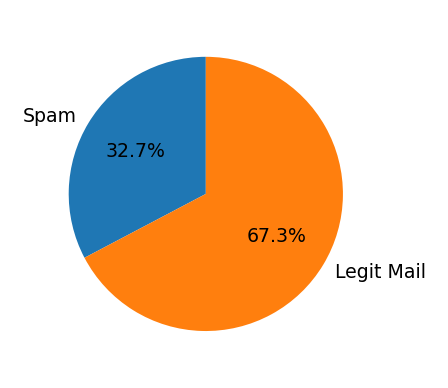

In [278]:
category_names=['Spam', 'Legit Mail']
sizes= [amount_of_spam, amount_of_ham]

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize':6}, startangle=90, autopct='%1.1f%%')
plt.show()

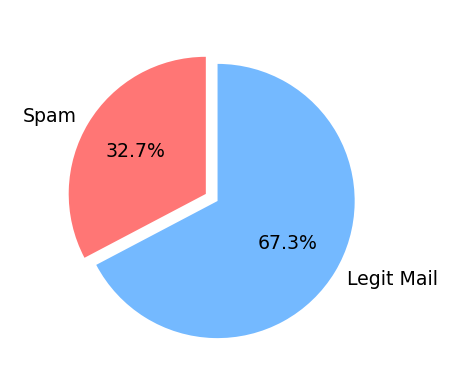

In [279]:
category_names=['Spam', 'Legit Mail']
sizes= [amount_of_spam, amount_of_ham]

custom_colours=['#ff7675','#74b9ff']
plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize':6}, startangle=90, autopct='%1.1f%%',colors=custom_colours, 
        explode=[0, 0.1])
plt.show()

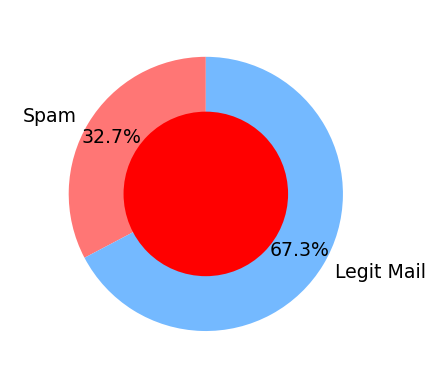

In [280]:
category_names=['Spam', 'Legit Mail']
sizes= [amount_of_spam, amount_of_ham]

custom_colours=['#ff7675','#74b9ff']
plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize':6}, startangle=90, autopct='%1.1f%%',colors=custom_colours, 
        pctdistance=0.8)

#draw circle
centre_circle = plt.Circle((0,0),radius=0.6, fc='red')
plt.gca().add_artist(centre_circle)

plt.show()

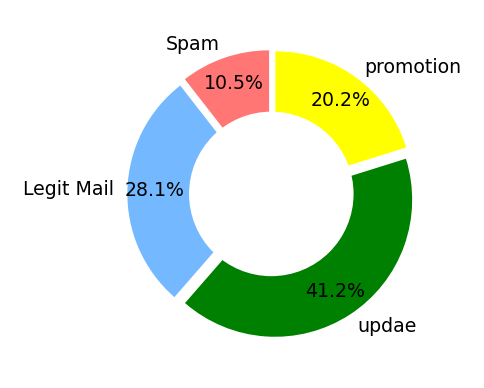

In [281]:
category_names=['Spam', 'Legit Mail','updae', 'promotion']
sizes= [12,32,47,23]

custom_colours=['#ff7675','#74b9ff','green', 'yellow']
offset=[0.05, 0.05,0.05, 0.05]

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize':6}, startangle=90, autopct='%1.1f%%',colors=custom_colours, 
        pctdistance=0.8, explode=offset)

#draw circle
centre_circle = plt.Circle((0,0),radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

## Natural Language Processing
### Text Pre-Processing

In [282]:
# convert to lower case
msg= 'All work and no play maks JaCK A DULL'
msg.lower()

'all work and no play maks jack a dull'

### Download the NLTK Resources (Tokenizers and Stopwords)

In [283]:
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [284]:
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

## Tokenising

In [285]:
msg='All work and no play maks JaCK A DULL'
word_tokenize(msg)

['All', 'work', 'and', 'no', 'play', 'maks', 'JaCK', 'A', 'DULL']

In [286]:
stopwords.words('english')
type(stopwords.words('english'))
set(stopwords.words('english'))
stop_words=set(stopwords.words('english'))


In [287]:
type(stop_words)

set

In [288]:
if 'this' in stop_words: print('found it')

found it


In [289]:
if 'this' in stop_words:
    print('found it')
else:
    print('nope')

found it


In [290]:
if 'hello' not in stop_words: print('nope, not here')

nope, not here


In [291]:
msg='All work and no play maks JaCK A DULL'
words= word_tokenize(msg.lower())

filtered_words=[]

for word in words:
    if word not in stop_words:
        filtered_words.append(word)
        
print(filtered_words)


['work', 'play', 'maks', 'jack', 'dull']


In [292]:
msg='All work and no play maks JaCK A DULL. To be or not To Be.\ Nobody expects the Spanish Inquisition !'
words= word_tokenize(msg.lower())

stemmer=PorterStemmer()

#take note of other stemmers e.g stemmer=SnowballStemmer('english')

filtered_words=[]

for word in words:
    if word not in stop_words:
        stemmed_word=stemmer.stem(word)
        filtered_words.append(stemmed_word)
        
print(filtered_words)

['work', 'play', 'mak', 'jack', 'dull', '.', 'be.\\', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


### Removing Punctuation marks

In [293]:
msg='All work and no play maks JaCK A DULL. To be or not To Be.\ Nobody expects the Spanish Inquisition !'
words= word_tokenize(msg.lower())


stemmer=SnowballStemmer('english')

filtered_words=[]

for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word=stemmer.stem(word)
        filtered_words.append(stemmed_word)
        
print(filtered_words)

['work', 'play', 'mak', 'jack', 'dull', 'nobodi', 'expect', 'spanish', 'inquisit']


In [294]:
'p'.isalpha()

True

In [295]:
'?'.isalpha()

False

## Removing HTML Tags from Email

In [296]:
data.at[2,'MESSAGE']

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

In [297]:
soup=BeautifulSoup(data.at[2,'MESSAGE'], 'html.parser')
print(soup.prettify())

1) Fight The Risk of Cancer!

http://www.adclick.ws/p.cfm?o=315&amp;s=pk007



2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days

http://www.adclick.ws/p.cfm?o=249&amp;s=pk007



3) Get the Child Support You Deserve - Free Legal Advice

http://www.adclick.ws/p.cfm?o=245&amp;s=pk002



4) Join the Web's Fastest Growing Singles Community

http://www.adclick.ws/p.cfm?o=259&amp;s=pk007



5) Start Your Private Photo Album Online!

http://www.adclick.ws/p.cfm?o=283&amp;s=pk007



Have a Wonderful Day,

Offer Manager

PrizeMama



























If you wish to leave this list please use the link below.

http://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417



In [298]:
soup.get_text()

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

## Functions for Email Processing

In [299]:
def clean_message(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [300]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [301]:
# Challenge: Modify function to remove HTML tags. Then test on Email with DOC_ID 2. 
def clean_msg_no_html(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Remove HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
#             filtered_words.append(word) 
    
    return filtered_words

In [302]:

clean_msg_no_html(data.at[2, 'MESSAGE'])

['fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'child',
 'support',
 'deserv',
 'free',
 'legal',
 'advic',
 'http',
 'join',
 'web',
 'fastest',
 'grow',
 'singl',
 'commun',
 'http',
 'start',
 'privat',
 'photo',
 'album',
 'onlin',
 'http',
 'wonder',
 'day',
 'offer',
 'manag',
 'prizemama',
 'wish',
 'leav',
 'list',
 'pleas',
 'use',
 'link',
 'http',
 'zzzz']

## Apply Cleaning and Tokenisation to all messages

### Slicing DataFrames and series & Creating Subsets

In [303]:
data.iat[2,0]

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

In [304]:
data.iloc[5:11]

MESSAGE  CATEGORY  \
DOC_ID                                                                
5       A POWERHOUSE GIFTING PROGRAM You Don't Want To...         1   
6       Help wanted.  We are a 14 year old fortune 500...         1   
7       <html>\n\n<head>\n\n<title>ReliaQuote - Save U...         1   
8       TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...         1   
9       Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...         1   
10      Cellular Phone Accessories All At Below Wholes...         1   

                                     FILE_NAME  
DOC_ID                                          
5       00006.5ab5620d3d7c6c0db76234556a16f6c1  
6       00007.d8521faf753ff9ee989122f6816f87d7  
7       00008.dfd941deb10f5eed78b1594b131c9266  
8       00009.027bf6e0b0c4ab34db3ce0ea4bf2edab  
9       00010.445affef4c70feec58f9198cfbc22997  
10      00011.61816b9ad167657773a427d890d0468e

In [305]:
data.MESSAGE.iloc[0:3]

DOC_ID
0    <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...
1    1) Fight The Risk of Cancer!\n\nhttp://www.adc...
2    1) Fight The Risk of Cancer!\n\nhttp://www.adc...
Name: MESSAGE, dtype: object

In [306]:
first_emails=data.MESSAGE.iloc[0:3]
nested_list=first_emails.apply(clean_message)

In [307]:
nested_list

DOC_ID
0    [doctyp, html, public, html, html, head, meta,...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
Name: MESSAGE, dtype: object

In [308]:
# flat_list =[]
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

flat_list=[item for sublist in nested_list for item in sublist] #check this and compare
        
len(flat_list)

321

In [309]:
flat_list

['doctyp',
 'html',
 'public',
 'html',
 'html',
 'head',
 'meta',
 'ype',
 'meta',
 'mshtml',
 'bodi',
 'insert',
 'calypso',
 'tabl',
 'color',
 'black',
 'display',
 'none',
 'tbodi',
 'tr',
 'td',
 'hr',
 'noshad',
 'tr',
 'td',
 'hr',
 'noshad',
 'end',
 'calypso',
 'insert',
 'font',
 'arial',
 'helvetica',
 'br',
 'end',
 'calypso',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'save',
 'life',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'spend',
 'center',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'life',
 'quot',
 'save',
 'center',
 'p',
 'p',
 'br',
 'p',
 'center',
 'tabl',
 'tbodi',
 'tabl',
 'tbodi',
 'tr',
 'td',
 'b',
 'font',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'tr',
 'td',
 'tabl',
 'tbodi',
 'tr',
 'td',
 'font',
 'b',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',

In [310]:
%%time

# use apply() on all the messages in the dataframe
nested_list= data.MESSAGE.apply(clean_msg_no_html)
nested_list

C:\Users\HP USER\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\HP USER\anaconda3\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


CPU times: total: 1min 1s
Wall time: 1min 1s


DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 5796, dtype: object

In [311]:
nested_list.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

In [312]:
nested_list.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

## Using Logic to Slice DataFrames

In [313]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [314]:
data[data.CATEGORY == 1].tail()

MESSAGE  CATEGORY  \
DOC_ID                                                                
1891    <html>\n\n<head>\n\n<meta http-equiv="content-...         1   
1892    This is a multi-part message in MIME format.\n...         1   
1893    Dear Subscriber,\n\n\n\nIf I could show you a ...         1   
1894    ****Mid-Summer Customer Appreciation SALE!****...         1   
1895    ATTN:SIR/MADAN      \n\n\n\n                  ...         1   

                                     FILE_NAME  
DOC_ID                                          
1891    01396.e80a10644810bc2ae3c1b58c5fd38dfa  
1892    01397.f75f0dd0dd923faefa3e9cc5ecb8c906  
1893    01398.8ca7045aae4184d56e8509dc5ad6d979  
1894    01399.2319643317e2c5193d574e40a71809c2  
1895    01400.b444b69845db2fa0a4693ca04e6ac5c5

In [315]:
#Create two variables (doc_ids_spam, doc-ids_ham) which hold onto the indices for the spam and the non-spam emails 
# respectively

In [316]:
doc_ids_spam= data[data.CATEGORY==1].index
doc_ids_ham= data[data.CATEGORY==0].index

In [317]:
doc_ids_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

## Subsetting a Series with an index

In [318]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [319]:
type(nested_list)

pandas.core.series.Series

In [320]:
nested_list_ham=nested_list.loc[doc_ids_ham]

In [321]:
nested_list_ham.shape

(3900,)

In [322]:
nested_list_ham.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

In [323]:
nested_list_spam=nested_list.loc[doc_ids_spam]

In [324]:
#challege: use 

In [325]:
flat_list_ham= [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham)

normal_words.shape[0] #total number of words inthe non-spam messages

442046

In [326]:
flat_list_ham= [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0] #total number of unique words inthe non-spam messages

20814

In [327]:
normal_words[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

In [328]:
flat_list_spam= [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0] #total number of unique words inthe spam messages

13241

In [329]:
spammy_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

## Creating a Word Cloud

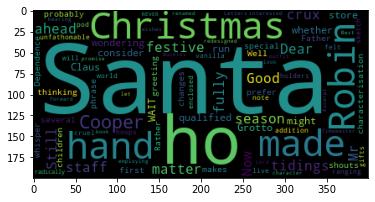

In [332]:
word_cloud= WordCloud().generate(email_body)
plt.imshow(word_cloud)
plt.show()

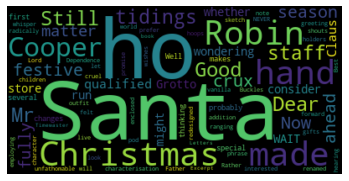

In [334]:
word_cloud= WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [336]:
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to C:\Users\HP
[nltk_data]     USER\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\gutenberg.zip.


True

In [337]:
example_corpus=nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [338]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [340]:
example_corpus.head()

AttributeError: 'StreamBackedCorpusView' object has no attribute 'head'

In [341]:
example_corpus

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [345]:
word_list=[''.join(word) for word in example_corpus]
novel_as_string= ' '.join(word_list)
novel_as_string

'[ Moby Dick by Herman Melville 1851 ] ETYMOLOGY . ( Supplied by a Late Consumptive Usher to a Grammar School ) The pale Usher -- threadbare in coat , heart , body , and brain ; I see him now . He was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world . He loved to dust his old grammars ; it somehow mildly reminded him of his mortality . " While you take in hand to school others , and to teach them by what name a whale - fish is to be called in our tongue leaving out , through ignorance , the letter H , which almost alone maketh the signification of the word , you deliver that which is not true ." -- HACKLUYT " WHALE . ... Sw . and Dan . HVAL . This animal is named from roundness or rolling ; for in Dan . HVALT is arched or vaulted ." -- WEBSTER \' S DICTIONARY " WHALE . ... It is more immediately from the Dut . and Ger . WALLEN ; A . S . WALW - IAN , to roll , to wallow ." -- RICHA

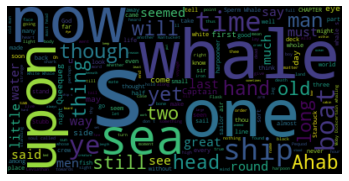

In [346]:
word_cloud= WordCloud().generate(novel_as_string)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')


plt.show()

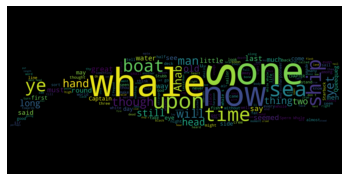

In [354]:
icon=Image.open(WHALE_FILE)
image_mask=Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)

rgb_array=np.array(image_mask) # converts the image object to an array

word_cloud= WordCloud(mask=rgb_array).generate(novel_as_string)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

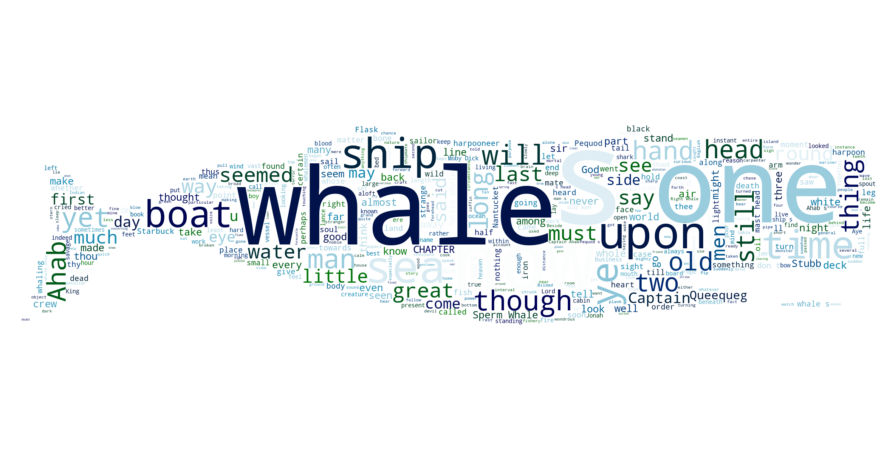

In [361]:
icon=Image.open(WHALE_FILE)
image_mask=Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)

rgb_array=np.array(image_mask) # converts the image object to an array

word_cloud= WordCloud(mask=rgb_array, background_color='white', max_words=450, colormap='ocean').generate(novel_as_string)
plt.figure(figsize=(16,8))
plt.imshow(word_cloud, interpolation='bilinear')

plt.axis('off')
plt.show()

In [359]:
rgb_array
rgb_array.shape

(1024, 2048, 3)

In [360]:
rgb_array[1023, 2047]

array([255, 255, 255], dtype=uint8)

In [363]:
57+9

66

In [ ]:
nltk.download('')

In [ ]:
hamlet_corpus= nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list=[''.join(word) for word in hamlet_corpus]
hamlet_as_string = ' '.join(word_list)

skull_icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB', size=skull_icon.size, color=(225,225,225))
rgb_array=np.array(image_mask)

word_cloud= WordCloud(mask=rgb_array, background_color='white', colormap='bone', max_words=50)

word_cloud.generate(hamlet_as_string)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Word Cloud of Ham and Spam Messages

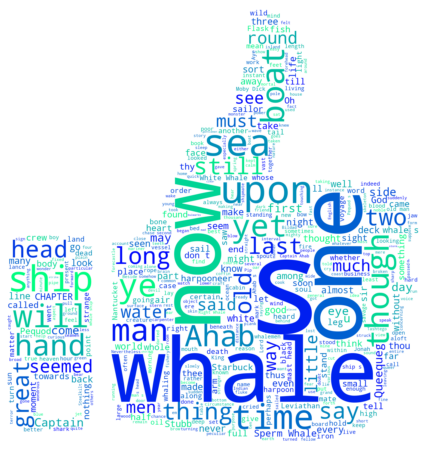

In [366]:
icon=Image.open(THUMBS_UP_FILE)
image_mask=Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)

rgb_array=np.array(image_mask) # converts the image object to an array

# generate the text as a string for the word cloud
ham_str= ' '.join(flat_list_ham)

word_cloud= WordCloud(mask=rgb_array, background_color='white', max_words=450, colormap='winter').generate(novel_as_string)
plt.figure(figsize=(16,8))
plt.imshow(word_cloud, interpolation='bilinear')

plt.axis('off')
plt.show()

In [ ]:
# Challege: fonts, 

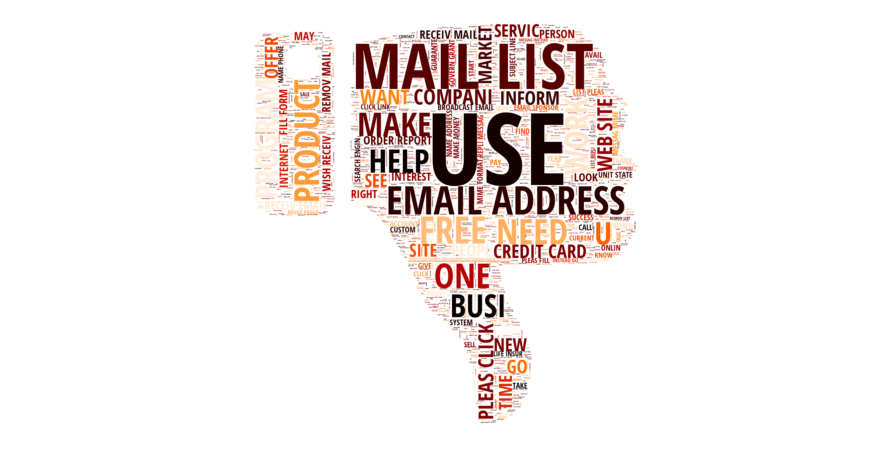

In [370]:
icon=Image.open(THUMBS_DOWN_FILE)
image_mask=Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)

rgb_array=np.array(image_mask) # converts the image object to an array

# generate the text as a string for the word cloud
spam_str= ' '.join(flat_list_spam)

word_cloud= WordCloud(mask=rgb_array, background_color='white', max_words=2000, colormap='gist_heat', font_path=
                     CUSTOM_FONT_FILE, max_font_size=300).generate(spam_str.upper())
plt.figure(figsize=(16,8))
plt.imshow(word_cloud, interpolation='bilinear')

plt.axis('off')
plt.show()

## Generate Vocabuary & Dictionary

In [371]:
stemmed_nested_list=data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list=[item for sublist in stemmed_nested_list for item in sublist]


C:\Users\HP USER\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\HP USER\anaconda3\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [372]:
unique_words=pd.Series(flat_stemmed_list).value_counts()
print ('Nr of unique words', unique_words.shape[0])
unique_words.head()

Nr of unique words 27332


http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [375]:
frequent_words= unique_words[0:VOCAB_SIZE]
print('Most common words: \n', frequent_words[:10])

Most common words: 
 http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64


## Create vocabulary DataFrame with a WORD_ID

In [378]:
word_ids=list(range(0,VOCAB_SIZE))
vocab=pd.DataFrame({'VOCAB_WORD':frequent_words.index.values}, index=word_ids)
vocab.index.name='WORD_ID'
vocab.head()

VOCAB_WORD
WORD_ID           
0             http
1              use
2             list
3            email
4              get

## Save the Vocabulary as CSV File

In [380]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

## Exercise: Checking if a word is part of the Vocabulary

In [381]:
#'machine', 'learning', 'fun', 'learn', 'data', 'science'


In [383]:
any(vocab.VOCAB_WORD == 'machin')

True

In [387]:
'learning' in set(vocab.VOCAB_WORD) # better way

False

## Exercise: Find the Email with the Most Number of Words

In [388]:
# Challenge: Print out the number of words in the longest email( after cleaning and stemming)
# Note the Longest email's position in the list of the cleaned emails. print out the stemmed list of words in the longest email.
#print out the longest email from the data dataframe

In [389]:
#for loop
clean_email_lengths=[]
for sublist in stemmed_nested_list:
    clean_email_lengths.append(len(sublist))

In [390]:
print(clean_email_lengths)

[92, 56, 44, 206, 45, 161, 47, 162, 203, 44, 55, 23, 44, 74, 64, 235, 47, 208, 36, 56, 223, 192, 0, 93, 14, 208, 44, 18, 64, 95, 312, 56, 141, 72, 55, 1065, 48, 139, 2, 90, 78, 4, 47, 70, 44, 75, 38, 12, 38, 63, 47, 51, 71, 80, 25, 275, 36, 63, 19, 18, 14, 40, 57, 18, 77, 28, 102, 41, 226, 68, 120, 5, 52, 0, 40, 40, 208, 0, 40, 145, 62, 114, 64, 253, 1221, 49, 0, 65, 52, 145, 15, 0, 90, 70, 2, 198, 50, 50, 50, 214, 119, 43, 80, 44, 315, 243, 9, 36, 98, 26, 52, 333, 47, 42, 0, 38, 78, 97, 79, 55, 102, 34, 70, 55, 18, 129, 50, 0, 39, 74, 43, 72, 47, 80, 0, 28, 223, 97, 0, 58, 84, 214, 75, 47, 18, 104, 20, 114, 110, 187, 6, 40, 54, 79, 276, 110, 208, 6, 489, 62, 17, 175, 79, 47, 74, 82, 255, 33, 218, 38, 36, 110, 93, 61, 55, 41, 108, 80, 84, 0, 52, 1390, 108, 97, 25, 185, 1, 119, 255, 28, 137, 195, 177, 0, 98, 109, 1465, 0, 108, 150, 113, 38, 153, 38, 42, 0, 0, 383, 188, 77, 330, 14, 92, 92, 104, 372, 187, 241, 143, 254, 14, 98, 135, 222, 65, 90, 226, 217, 129, 38, 94, 204, 255, 215, 146,

In [391]:
# Python List Comprehension
clean_email_lengths=[len(sublist) for sublist in stemmed_nested_list]
print('Nr words in the longest email:', max(clean_email_lengths))

Nr words in the longest email: 7671


In [392]:
print('Email position in the list (and the data dataframe)', np.argmax(clean_email_lengths))

Email position in the list (and the data dataframe) 5775


In [393]:
stemmed_nested_list[np.argmax(clean_email_lengths)]

['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [394]:
data.at[np.argmax(clean_email_lengths), 'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Generate Features & a Sparse Matrix

## Creating a DataFrame with one Word per Column

In [395]:
type(stemmed_nested_list)

pandas.core.series.Series

In [396]:
type(stemmed_nested_list.tolist())

list

In [397]:
stemmed_nested_list.tolist()

[['save',
  'life',
  'insur',
  'spend',
  'life',
  'quot',
  'save',
  'g',
  'famili',
  'financi',
  'secur',
  'import',
  'life',
  'quot',
  'save',
  'ke',
  'buy',
  'life',
  'insur',
  'simpl',
  'afford',
  'provid',
  'free',
  'access',
  'best',
  'compani',
  'lowest',
  'rate',
  'life',
  'quot',
  'save',
  'fast',
  'save',
  'money',
  'let',
  'us',
  'help',
  'get',
  'start',
  'best',
  'ue',
  'countri',
  'new',
  'coverag',
  'save',
  'hundr',
  'even',
  'usand',
  'dollar',
  'request',
  'free',
  'quot',
  'lifequot',
  'save',
  'servic',
  'take',
  'less',
  'minut',
  'complet',
  'shop',
  'compar',
  'save',
  'type',
  'life',
  'insur',
  'click',
  'free',
  'quot',
  'protect',
  'famili',
  'best',
  'invest',
  'r',
  'make',
  'receipt',
  'email',
  'error',
  'wish',
  'remov',
  'list',
  'pleas',
  'click',
  'type',
  'remov',
  'resid',
  'state',
  'prohibit',
  'solicit',
  'ce',
  'pleas',
  'disregard',
  'email'],
 ['fight',
  

In [398]:
word_columns_df=pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

0      1       2      3           4         5       6     7       8     \
0     save   life   insur  spend        life      quot    save     g  famili   
1    fight   risk  cancer   http        slim  guarante    lose    lb     day   
2    fight   risk  cancer   http        slim  guarante    lose    lb     day   
3    adult   club   offer   free  membership   instant  access  site    user   
4  thought  might    like   slim    guarante      lose      lb   day    http   

      9     ...  7661  7662  7663  7664  7665  7666  7667  7668  7669  7670  
0  financi  ...  None  None  None  None  None  None  None  None  None  None  
1     http  ...  None  None  None  None  None  None  None  None  None  None  
2     http  ...  None  None  None  None  None  None  None  None  None  None  
3     name  ...  None  None  None  None  None  None  None  None  None  None  
4    fight  ...  None  None  None  None  None  None  None  None  None  None  

[5 rows x 7671 columns]

In [399]:
word_columns_df.shape


(5796, 7671)

## Splitting the Data into a Training and Testing Dataset

In [400]:
# Challenge: Can you split the data into a training and testing set? set the test size at 30%.
# The Training data should include 4057 emails. use a seed value of 42 to shuffle the data.
# what should the target values be?

In [411]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY, test_size=0.3, random_state=42)

In [414]:
print('Nr of training samples', X_train.shape[0])
print('Fraction of training set', X_train.shape[0] / word_columns_df.shape[0])

Nr of training samples 4057
Fraction of training set 0.6999654934437544


In [417]:
X_train.index.name= X_test.index.name ="DOC_ID"
X_train.head()

0       1      2          3            4      5        6     \
DOC_ID                                                                   
4844         ye    inde  agent  directori       verita     cd     unix   
4727    problem    come    tri     instal  harddissssk   like  alreadi   
5022     origin  messag   date        mon          aug   chad  norwood   
3504      inlin    folk  sever      major     internet  outag     morn   
3921        url    http   date       bath     chronicl   None     None   

                7      8        9     ...  7661  7662  7663  7664  7665  7666  \
DOC_ID                                ...                                       
4844    subdirectori   file     call  ...  None  None  None  None  None  None   
4727           mount   http    yahoo  ...  None  None  None  None  None  None   
5022            sven     cc  subject  ...  None  None  None  None  None  None   
3504          across  major   provid  ...  None  None  None  None  None  None   
3921            None   None     None  ...  None  None  None  None  None  None   

        7667  7668  7669  7670  
DOC_ID                          
4844    None  None  None  None  
4727    None  None  None  None  
5022    None  None  None  None  
3504    None  None  None  None  
3921    None  None  None  None  

[5 rows x 7671 columns]

In [419]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

## Create a Sparse Matrix for the Training Data

In [420]:
word_index=pd.Index(vocab.VOCAB_WORD)
type(word_index)

pandas.core.indexes.base.Index

In [421]:
type(word_index[3])

str

In [422]:
word_index.get_loc('thu')

393

In [424]:
X_train.index[0]

4844

In [425]:
word_index.get_loc('unusu')

2351

In [432]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe.
    
    
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train or y_test)
    """
    
    nr_rows= df.shape[0]
    nr_cols=df.shape[1]
    
    word_set=set(indexed_words)
    dict_list=[]
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word=df.iat[i,j]
            if word in word_set:
                doc_id=df.index[i]
                word_id= indexed_words.get_loc(word)
                category=labels.at[doc_id]
                
                item={ 'LABEL': category, 'DOC_ID': doc_id, 'OCCURENCE':1, 'WORD_ID':word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [433]:
%%time

sparse_train_df=make_sparse_matrix(X_train, word_index, y_train)

CPU times: total: 14min 20s
Wall time: 14min 39s


In [437]:
sparse_train_df[:5]

LABEL  DOC_ID  OCCURENCE  WORD_ID
0      0    4844          1      265
1      0    4844          1     1239
2      0    4844          1      504
3      0    4844          1      308
4      0    4844          1      254

## Combine Occurrences with the Pandas groupby() Method

In [460]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [439]:
vocab.at[0, 'VOCAB_WORD']

'http'

In [442]:
train_grouped.shape

(258332, 1)

## Save Training Data as .txt File

In [458]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [459]:
train_grouped.columns

Index(['OCCURENCE'], dtype='object')

## Challenge
### Can you create a sparse matrix for the test data. Group the Occurences of the same word in the same email. then save the data as .txt file

In [445]:
y_test.head()

DOC_ID
4675    0
4220    0
2484    0
2418    0
5110    0
Name: CATEGORY, dtype: int64

In [446]:
X_test.shape

(1739, 7671)

In [447]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

CPU times: total: 6min 10s
Wall time: 6min 16s


In [449]:
sparse_test_df.shape

(203404, 4)

In [451]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()

DOC_ID  WORD_ID  LABEL  OCCURENCE
0       8        2      1          1
1       8        3      1          4
2       8        4      1          2
3       8        5      1          1
4       8        6      1          2

In [452]:
test_grouped.shape

(117774, 4)

In [455]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

## Pre-Processing Subtleties and Checking your Understanding

challenge : we started with 5796 emails. We split it into 40

In [466]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

AttributeError: 'DataFrame' object has no attribute 'DOC_ID'

In [463]:
len(test_doc_ids)

NameError: name 'test_doc_ids' is not defined

In [ ]:
set(X_test.index.values) - test_doc_ids

In [467]:
data.MESSAGE[14]

'<HTML><HEAD><TITLE>Lowest Rate Services</TITLE>\n\n<META http-equiv=3DContent-Type content=3D"text/html; charset=3Dwindows-12=\n\n52">\n\n<META content=3D"MSHTML 5.50.4134.600" name=3DGENERATOR></HEAD>\n\n<BODY vLink=3D#c0c0c0 link=3D#c0c0c0 bgColor=3D#000033 leftMargin=3D0><FON=\n\nT \n\nface=3Darial,helvetica>\n\n<P>\n\n<CENTER>\n\n<TABLE width=3D600 border=3D0>\n\n  <TBODY>\n\n  <TR>\n\n    <TD align=3Dmiddle><B><FONT color=3D#999999 size=3D6>Conferencing Made=\n\n Easy</FONT><BR>\n\n<FONT color=3D#999999 size=3D5>Only <U>18 Cents</U> Per Minute!</B></FONT>=\n\n</TD></TR></TBODY></TABLE>\n\n<P><FONT color=3D#ff0000 size=3D5><B>(Including Long Distance!)</B></FONT>=\n\n \n\n<P>\n\n<TABLE width=3D350 border=3D0>\n\n  <TBODY>\n\n  <TR>\n\n    <TD><FONT color=3D#999999 size=3D3><B>\n\n      <LI>No setup fees \n\n      <LI>No contracts or monthly fees \n\n      <LI>Call anytime, from anywhere, to anywhere \n\n      <LI>Connects up to 100 Participants \n\n      <LI>Simplicity in set up a

In [469]:
data.loc[14]

MESSAGE      <HTML><HEAD><TITLE>Lowest Rate Services</TITLE...
CATEGORY                                                     1
FILE_NAME               00015.048434ab64c86cf890eda1326a5643f5
Name: 14, dtype: object

In [470]:
clean_msg_no_html(data.at[14, 'MESSAGE'])

['lowest',
 'rate',
 'servic',
 'conferenc',
 'easi',
 'cent',
 'per',
 'minut',
 'includ',
 'long',
 'distanc',
 'setup',
 'fee',
 'contract',
 'monthli',
 'fee',
 'call',
 'anytim',
 'anywher',
 'anywher',
 'connect',
 'particip',
 'simplic',
 'set',
 'administr',
 'oper',
 'help',
 'avail',
 'highest',
 'qualiti',
 'servic',
 'lowest',
 'rate',
 'industri',
 'fill',
 'form',
 'low',
 'find',
 'lower',
 'phone',
 'bill',
 'everi',
 'requir',
 'input',
 'field',
 'name',
 'web',
 'address',
 'compani',
 'name',
 'state',
 'busi',
 'phone',
 'home',
 'phone',
 'email',
 'address',
 'type',
 'busi',
 'remov',
 'distribut',
 'list',
 'pleas',
 'click']

In [471]:
data.MESSAGE[1096]

'Dear fellow eBay user,\n\n\n\nI listed this CD on eBay a few months ago and here\'s \n\nwhat happened.  I got an email from Safeharbor saying \n\nthat all my auctions had been cancelled and that the CD \n\nwas permanently "banned" from being sold on eBay.  From \n\nthen on, I called it the "Banned CD"!\n\n\n\nSo why did eBay ban it?  Maybe they figured you shouldn\'t \n\nhave access to this type of information, or maybe they \n\ndidn\'t think we could cram all of these programs onto \n\none CD Rom.  I\'ll let you decide.\n\n\n\nThis CD will teach you things that eBay, Uncle Sam, and \n\nothers just don\'t want you to know.  I am not responsible \n\nfor how you use some of this information and it is \n\nprovided for educational purposes only.  Here are just a \n\nfew of the things you will learn ...\n\n\n\n*** Find confidential info on anyone in 30 minutes or \n\nless on the Internet.  \n\n\n\n    You\'ll be able to track down your old flame, find \n\n    out how much money your ex is 

In [472]:
clean_msg_no_html(data.at[1096, 'MESSAGE'])

['dear',
 'fellow',
 'ebay',
 'user',
 'list',
 'cd',
 'ebay',
 'month',
 'ago',
 'happen',
 'got',
 'email',
 'safeharbor',
 'say',
 'auction',
 'cancel',
 'cd',
 'perman',
 'ban',
 'sold',
 'ebay',
 'call',
 'ban',
 'cd',
 'ebay',
 'ban',
 'mayb',
 'figur',
 'access',
 'type',
 'inform',
 'mayb',
 'think',
 'could',
 'cram',
 'program',
 'onto',
 'one',
 'cd',
 'rom',
 'let',
 'decid',
 'cd',
 'teach',
 'thing',
 'ebay',
 'uncl',
 'sam',
 'other',
 'want',
 'know',
 'respons',
 'use',
 'inform',
 'provid',
 'educ',
 'purpos',
 'thing',
 'learn',
 'find',
 'confidenti',
 'info',
 'anyon',
 'minut',
 'less',
 'internet',
 'abl',
 'track',
 'old',
 'flame',
 'find',
 'much',
 'money',
 'ex',
 'hide',
 'bank',
 'account',
 'run',
 'background',
 'check',
 'proespect',
 'client',
 'employe',
 'even',
 'govern',
 'agenc',
 'troubl',
 'obtain',
 'much',
 'inform',
 'resourc',
 'profession',
 'investig',
 'right',
 'fingertip',
 'home',
 'comput',
 'list',
 'compani',
 'issu',
 'colleg',
 'd